### Faculdade de Engenharia Industrial - FEI

### Centro Universitário da Fundação Educacional Inaciana "Padre Sabóia de Medeiros" (FEI)


*FEI's Stricto Sensu Graduate Program in Electrical Engineering*

Concentration area: ARTIFICIAL INTELLIGENCE APPLIED TO AUTOMATION AND ROBOTICS

Master's thesis student Andre Luiz Florentino

***

## Select the processor type

In [1]:
# Select the way to load tensorflow in order to run on CPU only or CPU + GPU

import os

opc = 0
while str(opc) not in '12':
    print()
    print("1-) CPU only")
    print("2-) CPU + GPU")

    opc = input("\nSelect the processor: ")
    if opc.isdigit():
        opc = int(opc)
    else:
        opc = 0

if opc == 1:
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
    
    import tensorflow as tf

else:
    import tensorflow as tf
    print(tf.__version__)

    pd = tf.config.experimental.list_physical_devices()
    for i in pd:
        print(i)
    print('------------------------------------------------------------------------------------------')


    print(tf.config.list_physical_devices('GPU'))
    # [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

    print(tf.test.is_built_with_cuda)
    # <function is_built_with_cuda at 0x000001AA24AFEC10>

    print(tf.test.gpu_device_name())
    # /device:GPU:0

    #gvd = tf.config.get_visible_devices()
    for j in tf.config.get_visible_devices():
        print(j)
    # PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
    # PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')

    #physical_devices = tf.config.experimental.list_physical_devices()
    #tf.config.experimental.set_memory_growth(physical_devices[2], True)


1-) CPU only
2-) CPU + GPU



Select the processor:  1


## Check for GPU

In [2]:
if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")

No GPU found


# Chapter 11: ESR evaluation 

* Processing time;
* Memory allocation;
* Processing memory.

***

## Import modules

In [3]:
import psutil
import csv
import re
import sys

import pandas as pd
import numpy  as np

from collections import Counter
%load_ext memory_profiler

pd.set_option('display.max_columns', 9)
pd.set_option('display.width', 300)
pd.set_option('display.max_colwidth', 120)

In [4]:
# Globals
current_path = os.path.dirname(os.getcwd())

# For the picture names
pic_first_name = '11_ESR_evaluation_'

In [5]:
current_path

'/home/af21280raspi/Master_thesis_Andre_Luiz_Florentino_project-main'

In [6]:
root_path    = os.path.dirname(os.getcwd())
sys.path.insert(1, root_path)

## Data preparation

In [7]:
path        = os.path.join(current_path, "_dataset", "US8K_AV")
path_models = os.path.join(current_path, "US8K_AV_saved_models")
path_pic    = os.path.join(current_path, "US8K_AV_results")

path_modelsVal = os.path.join(current_path, "_ESR", "Saved_models_fold_1_validation")
path_arrays    = os.path.join(current_path, "_ESR", "Arrays")
path_raspi     = os.path.join(current_path, "Raspi")

nom_dataset    = 'US8K_AV' 
csv_file       = 'US8K_AV.csv'
fold_name      = '1'

pkl_features    = 'US8K_AV_features_original.pkl'
DB_ori_from_pkl = pd.read_pickle(os.path.join(path_models, pkl_features))

In [8]:
print(type(DB_ori_from_pkl['Fold'][0][0]))
print(type(DB_ori_from_pkl['Class_OHEV'][0][0]))
print(type(DB_ori_from_pkl['Class_OHEV'][0]))

<class 'str'>
<class 'numpy.int32'>
<class 'numpy.ndarray'>


In [9]:
DB_ori_from_pkl

,Audio,Class_categorical,Class_OHEV,Fold,...,TONNETZ_std_6,TONNETZ_median_6,TONNETZ_skew_6,TONNETZ_kurtosis_6
0,"[-0.0034710653, -0.0050192624, -0.004654482, -0.0049833283, -0.0038681468, -0.0023575649, -0.00025486574, 0.00135406...",dog_bark,"[0, 0, 0, 1, 0, 0]",5,...,0.024244,-0.049756,0.759231,-0.024962
1,"[0.0027405696, 0.0036386526, 0.0023064336, 0.0023546093, 0.0025339962, 0.0030277965, 0.0027998006, 0.0028241847, 0.0...",children_playing,"[0, 0, 1, 0, 0, 0]",5,...,0.018670,-0.018241,0.275013,-0.497943
2,"[-0.0027212622, -0.0030217567, -0.0016039186, -0.0012952066, -0.001044448, -0.0011087725, -0.0006573542, -0.00120615...",children_playing,"[0, 0, 1, 0, 0, 0]",5,...,0.018733,0.009139,-0.205466,-0.212879
3,"[0.00015050662, -0.00023231667, -0.0013628466, -0.002236663, -0.0027237535, -0.002267104, -0.0012131947, -0.00148792...",children_playing,"[0, 0, 1, 0, 0, 0]",5,...,0.027117,0.007208,-0.769827,0.623153
4,"[0.0012501464, 0.00428795, 0.0062407875, 0.0055125337, 0.003776363, 0.0018791268, 0.0014532767, 0.0026125484, 0.0038...",children_playing,"[0, 0, 1, 0, 0, 0]",5,...,0.025776,0.050245,0.208739,-1.062755
...,...,...,...,...,...,...,...,...,...
4903,"[0.0020684754, 0.002996013, 0.0027406309, 0.0031264792, 0.0030979805, 0.0032640784, 0.0030700786, 0.0029712087, 0.00...",silence,"[0, 0, 0, 0, 1, 0]",9,...,0.046910,-0.014152,1.014088,0.288518
4904,"[-0.00054763607, -0.0006439837, -0.0003565054, -0.00026786933, -0.00012919167, -0.0002218535, -0.00025803095, -0.000...",silence,"[0, 0, 0, 0, 1, 0]",9,...,0.048725,0.003801,-0.290986,-1.009455
4905,"[0.00036112632, 0.0003222265, -2.3932662e-05, -0.00028421593, -0.0005354925, -0.0005733533, -0.00046778092, -0.00020...",silence,"[0, 0, 0, 0, 1, 0]",9,...,0.032608,-0.043836,1.350900,2.272794
4906,"[-0.0002325126, -0.00035913184, -0.00025248923, -0.0001690893, 1.3734563e-05, 0.00021053397, 0.0003744613, 0.0003582...",silence,"[0, 0, 0, 0, 1, 0]",9,...,0.026508,-0.003402,-0.001074,-0.871445


In [10]:
DB_ori_from_pkl = DB_ori_from_pkl[['Audio', 'Class_categorical', 'Class_OHEV', 'Fold']]
DB_ori_from_pkl

,Audio,Class_categorical,Class_OHEV,Fold
0,"[-0.0034710653, -0.0050192624, -0.004654482, -0.0049833283, -0.0038681468, -0.0023575649, -0.00025486574, 0.00135406...",dog_bark,"[0, 0, 0, 1, 0, 0]",5
1,"[0.0027405696, 0.0036386526, 0.0023064336, 0.0023546093, 0.0025339962, 0.0030277965, 0.0027998006, 0.0028241847, 0.0...",children_playing,"[0, 0, 1, 0, 0, 0]",5
2,"[-0.0027212622, -0.0030217567, -0.0016039186, -0.0012952066, -0.001044448, -0.0011087725, -0.0006573542, -0.00120615...",children_playing,"[0, 0, 1, 0, 0, 0]",5
3,"[0.00015050662, -0.00023231667, -0.0013628466, -0.002236663, -0.0027237535, -0.002267104, -0.0012131947, -0.00148792...",children_playing,"[0, 0, 1, 0, 0, 0]",5
4,"[0.0012501464, 0.00428795, 0.0062407875, 0.0055125337, 0.003776363, 0.0018791268, 0.0014532767, 0.0026125484, 0.0038...",children_playing,"[0, 0, 1, 0, 0, 0]",5
...,...,...,...,...
4903,"[0.0020684754, 0.002996013, 0.0027406309, 0.0031264792, 0.0030979805, 0.0032640784, 0.0030700786, 0.0029712087, 0.00...",silence,"[0, 0, 0, 0, 1, 0]",9
4904,"[-0.00054763607, -0.0006439837, -0.0003565054, -0.00026786933, -0.00012919167, -0.0002218535, -0.00025803095, -0.000...",silence,"[0, 0, 0, 0, 1, 0]",9
4905,"[0.00036112632, 0.0003222265, -2.3932662e-05, -0.00028421593, -0.0005354925, -0.0005733533, -0.00046778092, -0.00020...",silence,"[0, 0, 0, 0, 1, 0]",9
4906,"[-0.0002325126, -0.00035913184, -0.00025248923, -0.0001690893, 1.3734563e-05, 0.00021053397, 0.0003744613, 0.0003582...",silence,"[0, 0, 0, 0, 1, 0]",9


In [11]:
for fold in np.unique(DB_ori_from_pkl['Fold']):
    print(f"Validation fold: {fold}")
    
    valsize = len(DB_ori_from_pkl[DB_ori_from_pkl['Fold'] == fold])
    trnsize = len(DB_ori_from_pkl[DB_ori_from_pkl['Fold'] != fold])
    print(f'dbComplete_VAL size: {valsize}')
    print(f'dbComplete size: {trnsize}')
    print()

Validation fold: 1
dbComplete_VAL size: 478
dbComplete size: 4430

Validation fold: 10
dbComplete_VAL size: 468
dbComplete size: 4440

Validation fold: 2
dbComplete_VAL size: 485
dbComplete size: 4423

Validation fold: 3
dbComplete_VAL size: 536
dbComplete size: 4372

Validation fold: 4
dbComplete_VAL size: 599
dbComplete size: 4309

Validation fold: 5
dbComplete_VAL size: 529
dbComplete size: 4379

Validation fold: 6
dbComplete_VAL size: 460
dbComplete size: 4448

Validation fold: 7
dbComplete_VAL size: 465
dbComplete size: 4443

Validation fold: 8
dbComplete_VAL size: 441
dbComplete size: 4467

Validation fold: 9
dbComplete_VAL size: 447
dbComplete size: 4461



In [12]:
# Reset the validation set to '1'

fold = '1'
fold

'1'

In [13]:
# Group by the class and get one random sample of each class
k = DB_ori_from_pkl.groupby('Class_categorical')['Class_OHEV'].apply(lambda s: s.sample(1))
print(k)

# Convert the pandas series into a dataframe
temp_k_df = k.reset_index()

# Delete the index from the grouppby result
del temp_k_df['level_1']

# Set the "Class" as the dataframe index
temp_k_df.set_index("Class_categorical", inplace=True)

# Convert the dataframe to a dictionary (Class: Class_encoder)
encoder_dict = temp_k_df["Class_OHEV"].to_dict()
encoder_dict

Class_categorical      
background         464     [1, 0, 0, 0, 0, 0]
car_horn           3746    [0, 1, 0, 0, 0, 0]
children_playing   1757    [0, 0, 1, 0, 0, 0]
dog_bark           596     [0, 0, 0, 1, 0, 0]
silence            4683    [0, 0, 0, 0, 1, 0]
siren              1456    [0, 0, 0, 0, 0, 1]
Name: Class_OHEV, dtype: object


{'background': array([1, 0, 0, 0, 0, 0], dtype=int32),
 'car_horn': array([0, 1, 0, 0, 0, 0], dtype=int32),
 'children_playing': array([0, 0, 1, 0, 0, 0], dtype=int32),
 'dog_bark': array([0, 0, 0, 1, 0, 0], dtype=int32),
 'silence': array([0, 0, 0, 0, 1, 0], dtype=int32),
 'siren': array([0, 0, 0, 0, 0, 1], dtype=int32)}

In [14]:
# Number of classes in the dataset

num_classes = len(encoder_dict.keys())
num_classes

6

In [15]:
for col in DB_ori_from_pkl.columns:
    print(col)

Audio
Class_categorical
Class_OHEV
Fold


In [16]:
# Separate 1 fold for validation and create a DB for the training / testing

DB_ori_from_pkl_VAL = DB_ori_from_pkl[DB_ori_from_pkl['Fold'] == fold_name].copy()
DB_ori_from_pkl_TRN = DB_ori_from_pkl[DB_ori_from_pkl['Fold'] != fold_name].copy()

In [17]:
print(len(DB_ori_from_pkl_VAL))
print(len(DB_ori_from_pkl_TRN))
print('Total: ', len(DB_ori_from_pkl_VAL) + len(DB_ori_from_pkl_TRN),'\n')

478
4430
Total:  4908 



In [18]:
audio_val = np.array(DB_ori_from_pkl_VAL.Audio.to_list())
y_val     = np.array(DB_ori_from_pkl_VAL.Class_OHEV.to_list())
y_val_cat = np.array(DB_ori_from_pkl_VAL.Class_categorical.to_list())

In [19]:
print(audio_val.shape)
print(y_val.shape)
print(y_val_cat.shape)

(478, 88200)
(478, 6)
(478,)


In [20]:
Counter_val_cat  = Counter(y_val_cat)
Counter_val      = Counter(map(tuple, y_val))

In [21]:
print('Validation categorical samples')
Counter_val_cat

Validation categorical samples


Counter({'background': 108,
         'dog_bark': 100,
         'children_playing': 100,
         'siren': 86,
         'silence': 48,
         'car_horn': 36})

In [22]:
print('Validation OHEV samples')
Counter_val

Validation OHEV samples


Counter({(1, 0, 0, 0, 0, 0): 108,
         (0, 0, 0, 1, 0, 0): 100,
         (0, 0, 1, 0, 0, 0): 100,
         (0, 0, 0, 0, 0, 1): 86,
         (0, 0, 0, 0, 1, 0): 48,
         (0, 1, 0, 0, 0, 0): 36})

### Results from the file 10_ESR_data_preparation.ipynb for confirming the predictions

In [23]:
predict_audioClip_dicR = np.load(os.path.join(path_arrays, '_predict_audioClip_dic.npy'), allow_pickle='TRUE').item()
predict_audio_dicR     = np.load(os.path.join(path_arrays, '_predict_audio_dic.npy'),     allow_pickle='TRUE').item()

In [24]:
saved_predict_val_SVC   = np.genfromtxt(os.path.join(path_arrays, '_saved_predict_val_SVC.csv'),   delimiter=',', dtype = str)
saved_predict_val_SVC   = np.char.strip(saved_predict_val_SVC, "'")
saved_predict_val_LR    = np.genfromtxt(os.path.join(path_arrays, '_saved_predict_val_LR.csv'),    delimiter=',', dtype = str)
saved_predict_val_LR    = np.char.strip(saved_predict_val_LR, "'")
saved_predict_val_RF    = np.genfromtxt(os.path.join(path_arrays, '_saved_predict_val_RF.csv'),    delimiter=',', dtype = str)
saved_predict_val_RF    = np.char.strip(saved_predict_val_RF, "'")
saved_predict_val_ANN   = np.genfromtxt(os.path.join(path_arrays, '_saved_predict_val_ANN.csv'),   delimiter=',', dtype = int)
saved_predict_val_CNN1D = np.genfromtxt(os.path.join(path_arrays, '_saved_predict_val_CNN1D.csv'), delimiter=',', dtype = int)
saved_predict_val_CNN2D = np.genfromtxt(os.path.join(path_arrays, '_saved_predict_val_CNN2D.csv'), delimiter=',', dtype = int)

In [25]:
print(np.array_equal(saved_predict_val_SVC,   predict_audioClip_dicR['predict_audioClip_SVC']))
print(np.array_equal(saved_predict_val_LR,    predict_audioClip_dicR['predict_audioClip_LR']))
print(np.array_equal(saved_predict_val_RF,    predict_audioClip_dicR['predict_audioClip_RF']))
print(np.array_equal(saved_predict_val_ANN,   predict_audioClip_dicR['predict_audioClip_ANN']))
print(np.array_equal(saved_predict_val_CNN1D, predict_audioClip_dicR['predict_audioClip_CNN1D']))
print(np.array_equal(saved_predict_val_CNN2D, predict_audioClip_dicR['predict_audioClip_CNN2D']))

True
True
True
True
True
True


In [26]:
# Retrive the ground truth label of each original audio

y_val_audio_cat = np.genfromtxt(os.path.join(path_arrays, '_y_val_audio_cat.csv'), delimiter=',', dtype = str)
y_val_audio_cat = np.char.strip(y_val_audio_cat, "'")
y_val_audio_enc = np.genfromtxt(os.path.join(path_arrays, '_y_val_audio_enc.csv'), delimiter=',', dtype = int)

In [27]:
# Retrive the ground truth label of each windowed audio

y_val_audio_wind_cat = np.genfromtxt(os.path.join(path_arrays, '_y_val_audio_wind_cat.csv'), delimiter=',', dtype = str)
y_val_audio_wind_cat = np.char.strip(y_val_audio_wind_cat, "'")
y_val_audio_wind_enc = np.genfromtxt(os.path.join(path_arrays, '_y_val_audio_wind_enc.csv'), delimiter=',', dtype = int)

### Evaluation algorithm

https://www.geeksforgeeks.org/magic-commands-for-profiling-in-jupyter-notebook/

In [28]:
from MT_ESR_evaluation import ESR_evaluation

In [29]:
Classifiers = ['SVC', 'LR', 'RF', 'ANN', 'CNN1D', 'CNN2D'] 

In [30]:
len(audio_val)

478

In [31]:
# Set the interval to define the number of original audio samples

shortInterval = (0,10)
fullInterval  = (0,len(audio_val))

print(f'Short interval..: {shortInterval}')
print(f'Full interval...: {fullInterval}')

Short interval..: (0, 10)
Full interval...: (0, 478)


In [32]:
opc = 0
while str(opc) not in '12':
    print()
    print("1-) Short interval (10 audio clips)")
    print("2-) Full interval  (430 audio clips, complete validation set)")

    opc = input("\nSelect the interval to define the number of samples: ")
    if opc.isdigit():
        opc = int(opc)
    else:
        opc = 0

if opc == 1:
    interval = shortInterval
    print(f'\nShort interval..: {interval}\n')
else:
    interval = fullInterval
    print(f'\nFull interval...: {interval}\n')


1-) Short interval (10 audio clips)
2-) Full interval  (430 audio clips, complete validation set)



Select the interval to define the number of samples:  1



Short interval..: (0, 10)



In [33]:
# Memory profile

def func(classifier: str, interval: tuple):
   
    ESR_EVAL = ESR_evaluation(audio_val[interval[0]:interval[1]], classifier, path_modelsVal, path_arrays)
    predictions    = np.array(ESR_EVAL.predictions)
    totalPredTime  = np.array(ESR_EVAL.totalPredTime)
    
    return predictions, totalPredTime

In [34]:
# Checking using one of the classifers

func('CNN2D', interval)

Sample...: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step
dog_bark
Total predict time:..: 5829.8416ms

Sample...: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
dog_bark
Total predict time:..: 309.7124ms

Sample...: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
dog_bark
Total predict time:..: 350.4891ms

Sample...: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
silence
Total predict time:..: 304.6006ms

Sample...: 5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
dog_bark
Total predict time:..: 354.6672ms

Sample...: 6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
dog_bark
Total predict time:..: 377.8257ms

Sample...: 7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
dog_bark
Total predict time:..: 345.5637ms

Sample...: 8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
dog_bark
Total predict time:..: 442.6183ms

Sample...: 9
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
dog_bark
Total predict time:..: 506.0807ms

Sample...: 10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
dog_bark
Total predict time:..: 536.2874ms

Sample...: 11
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80

(array([3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0]),
 array([5829.84162 ,  309.712424,  350.489146,  304.600561,  354.667229,
         377.825693,  345.563707,  442.618348,  506.080747,  536.287397,
         327.928506,  314.616849,  348.257277,  287.092749,  357.490259,
         325.732413,  283.732099,  300.834124,  321.588924,  368.131961,
         384.750754,  331.617432,  355.818825,  296.044664,  416.307197,
         391.6827  ,  413.483168,  451.39727 ,  328.444169,  322.213508,
         368.684308,  354.124132,  343.860128,  427.789313,  434.156231,
         289.694342,  488.806252,  467.564035,  548.836633,  346.010429,
         321.360932,  354.076913,  325.419183,  321.814296,  363.963553,
         344.685285,  322.797669,  397.551057,  356.358008,  384.64054 ,
         309.817006,  353.

In [35]:
%memit func('CNN2D', (0,1))

Sample...: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 799ms/step
dog_bark
Total predict time:..: 1080.6542ms

Sample...: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
dog_bark
Total predict time:..: 291.0571ms

Sample...: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
dog_bark
Total predict time:..: 439.2760ms

Sample...: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
silence
Total predict time:..: 367.4938ms

Sample...: 5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
dog_bark
Total predict time:..: 272.2894ms

Sample...: 6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
dog_bark
Total predict time:..: 310.8523ms

Sample...: 7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
dog_bark
Total predict time:..: 386.6891ms

peak memory: 2485.18 MiB, increment: 15.12 MiB


In [36]:
# Number of batches to be used while profiling the memory

batchLen = 10
batchLen

10

In [37]:
%%capture rawResult

for i in range(batchLen):
    for classifier in Classifiers:
        print(f'{classifier}_{i}')
        %memit func(classifier, interval)

In [38]:
results = rawResult.stdout
results

'SVC_0\nSample...: 1\ndog_bark\nTotal predict time:..: 1289.1779ms\n\nSample...: 2\ndog_bark\nTotal predict time:..: 918.4576ms\n\nSample...: 3\ndog_bark\nTotal predict time:..: 876.8868ms\n\nSample...: 4\nsilence\nTotal predict time:..: 1099.3406ms\n\nSample...: 5\ndog_bark\nTotal predict time:..: 916.8440ms\n\nSample...: 6\ndog_bark\nTotal predict time:..: 727.9865ms\n\nSample...: 7\ndog_bark\nTotal predict time:..: 686.0665ms\n\nSample...: 8\ndog_bark\nTotal predict time:..: 704.7037ms\n\nSample...: 9\ndog_bark\nTotal predict time:..: 703.9838ms\n\nSample...: 10\ndog_bark\nTotal predict time:..: 682.3814ms\n\nSample...: 11\ndog_bark\nTotal predict time:..: 671.6302ms\n\nSample...: 12\ndog_bark\nTotal predict time:..: 682.0657ms\n\nSample...: 13\ndog_bark\nTotal predict time:..: 818.1846ms\n\nSample...: 14\ndog_bark\nTotal predict time:..: 694.7098ms\n\nSample...: 15\ndog_bark\nTotal predict time:..: 712.3961ms\n\nSample...: 16\ndog_bark\nTotal predict time:..: 662.4710ms\n\nSample..

In [39]:
dicMem = {}
counter = 0

for line in results.split('\n'):
    if 'peak memory' in line:
        peak_memory = float(re.findall(r'peak memory: (\d+\.\d+)', line)[0])
        increment   = float(re.findall(r'increment: (\d+\.\d+)', line)[0])
        dicMem[counter] = {'peak memory': peak_memory, 'increment': increment}
        counter += 1

In [40]:
dicMem

{0: {'peak memory': 2514.76, 'increment': 54.25},
 1: {'peak memory': 2483.6, 'increment': 0.25},
 2: {'peak memory': 2971.35, 'increment': 487.75},
 3: {'peak memory': 2971.32, 'increment': 0.11},
 4: {'peak memory': 2498.75, 'increment': 5.61},
 5: {'peak memory': 2516.1, 'increment': 20.0},
 6: {'peak memory': 2528.5, 'increment': 28.0},
 7: {'peak memory': 2528.5, 'increment': 0.0},
 8: {'peak memory': 2982.0, 'increment': 453.5},
 9: {'peak memory': 2982.0, 'increment': 0.0},
 10: {'peak memory': 2502.15, 'increment': 8.62},
 11: {'peak memory': 2515.12, 'increment': 15.75},
 12: {'peak memory': 2529.82, 'increment': 28.12},
 13: {'peak memory': 2529.82, 'increment': 0.0},
 14: {'peak memory': 2983.69, 'increment': 453.88},
 15: {'peak memory': 2983.69, 'increment': 0.0},
 16: {'peak memory': 2504.17, 'increment': 3.25},
 17: {'peak memory': 2521.63, 'increment': 21.36},
 18: {'peak memory': 2532.19, 'increment': 28.0},
 19: {'peak memory': 2532.19, 'increment': 0.0},
 20: {'peak 

In [41]:
dicMem = {}
classifierNames = [f'{i}_{classifier}' for i in range(batchLen) for classifier in Classifiers]
classifierIndex = 0

for line in results.split('\n'):
    if 'peak memory' in line:
        peak_memory = float(re.findall(r'peak memory: (\d+\.\d+)', line)[0])
        increment   = float(re.findall(r'increment: (\d+\.\d+)', line)[0])
        dicMem[classifierNames[classifierIndex]] = {'peak memory': peak_memory, 'increment': increment}
        classifierIndex += 1

In [42]:
dicMem

{'0_SVC': {'peak memory': 2514.76, 'increment': 54.25},
 '0_LR': {'peak memory': 2483.6, 'increment': 0.25},
 '0_RF': {'peak memory': 2971.35, 'increment': 487.75},
 '0_ANN': {'peak memory': 2971.32, 'increment': 0.11},
 '0_CNN1D': {'peak memory': 2498.75, 'increment': 5.61},
 '0_CNN2D': {'peak memory': 2516.1, 'increment': 20.0},
 '1_SVC': {'peak memory': 2528.5, 'increment': 28.0},
 '1_LR': {'peak memory': 2528.5, 'increment': 0.0},
 '1_RF': {'peak memory': 2982.0, 'increment': 453.5},
 '1_ANN': {'peak memory': 2982.0, 'increment': 0.0},
 '1_CNN1D': {'peak memory': 2502.15, 'increment': 8.62},
 '1_CNN2D': {'peak memory': 2515.12, 'increment': 15.75},
 '2_SVC': {'peak memory': 2529.82, 'increment': 28.12},
 '2_LR': {'peak memory': 2529.82, 'increment': 0.0},
 '2_RF': {'peak memory': 2983.69, 'increment': 453.88},
 '2_ANN': {'peak memory': 2983.69, 'increment': 0.0},
 '2_CNN1D': {'peak memory': 2504.17, 'increment': 3.25},
 '2_CNN2D': {'peak memory': 2521.63, 'increment': 21.36},
 '3_S

In [43]:
classifierSum   = {}
classifierCount = {}

for key, value in dicMem.items():
    classifier = key.split('_')[1]

    if classifier not in classifierSum:
        classifierSum[classifier]   = {'peak memory': 0, 'increment': 0}
        classifierCount[classifier] = 0

    classifierSum[classifier]['peak memory'] += value['peak memory']
    classifierSum[classifier]['increment'] += value['increment']

    classifierCount[classifier] += 1

classifierAvg = {}

for classifier, sums in classifierSum.items():
    avgPeakMemory = sums['peak memory'] / classifierCount[classifier]
    avgIncrement = sums['increment'] / classifierCount[classifier]
    classifierAvg[classifier] = {'avg peak memory': avgPeakMemory, 'avg increment': avgIncrement}
    
for key, value in classifierAvg.items():
    print("{} {{'avg peak memory': {:.2f}, 'avg increment': {:.2f}}}".format(key, value['avg peak memory'], value['avg increment']))

SVC {'avg peak memory': 2534.32, 'avg increment': 32.44}
LR {'avg peak memory': 2531.20, 'avg increment': 0.03}
RF {'avg peak memory': 2987.17, 'avg increment': 455.96}
ANN {'avg peak memory': 2987.12, 'avg increment': 0.02}
CNN1D {'avg peak memory': 2507.73, 'avg increment': 4.13}
CNN2D {'avg peak memory': 2524.33, 'avg increment': 19.36}


In [45]:
# Save the file as CSV for futhers analysis in Excel

with open(os.path.join(path_raspi, '_totalPredMem_jupyter_tflite_Raspi.csv'), mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['key', 'peak_memory', 'increment'])
    for key, value in dicMem.items():
        writer.writerow([key, value['peak memory'], value['increment']])

### Run the python file:

* *MT_ESR_evaluation_tflite.py*

To profile the total time prediction.


### Compiled results from the file *_totalPredTime.csv* and *_totalPredMem_jupyter.csv*

Charts from Excel _TotalPredTime_training_flow_2024_06.xlsx

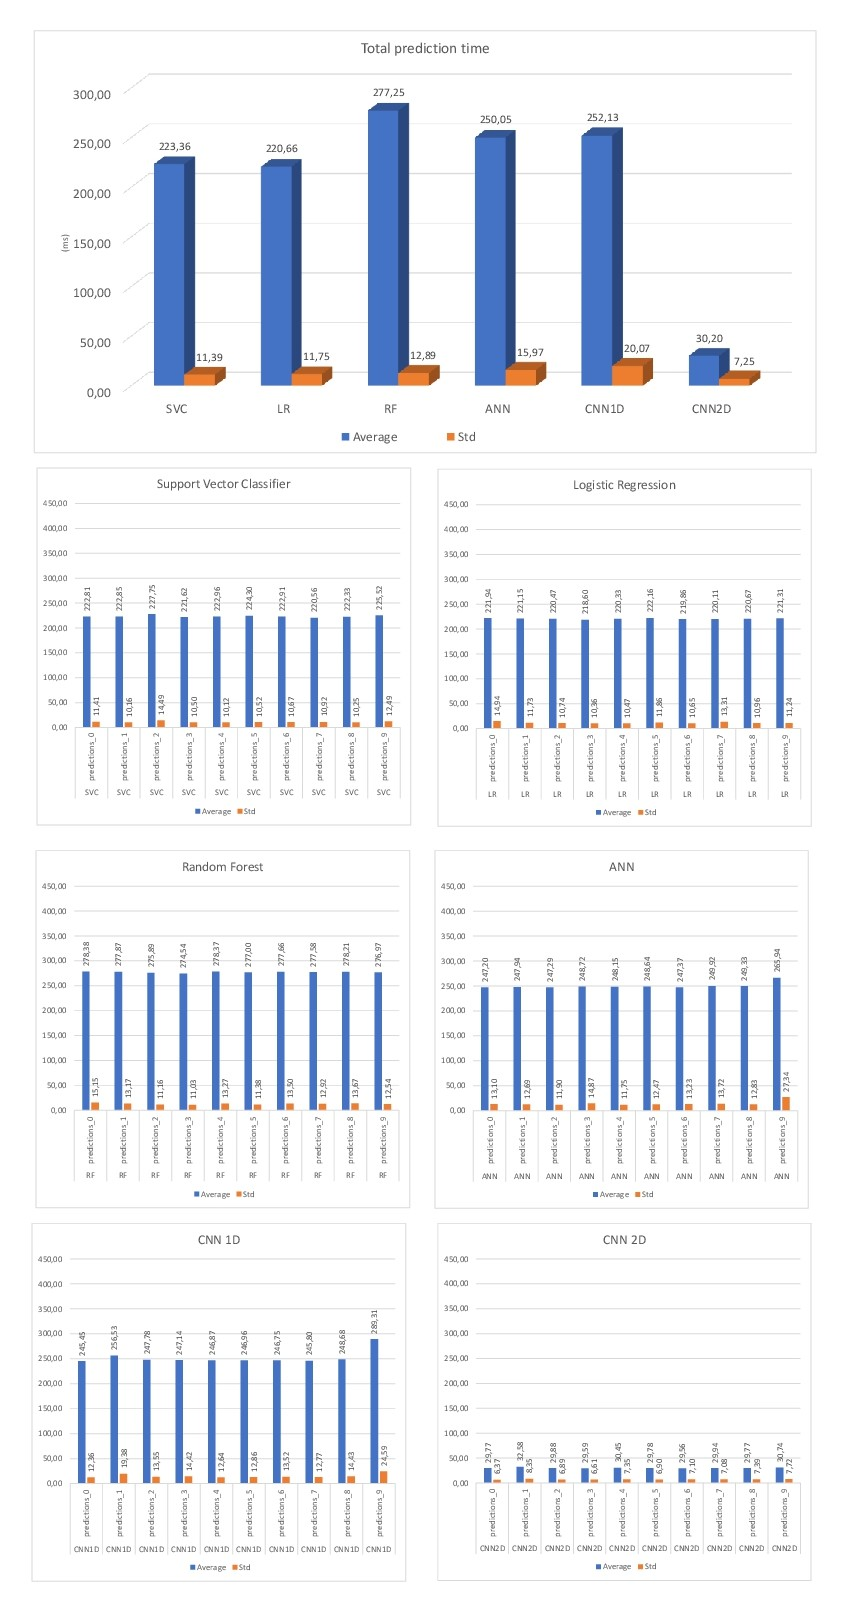

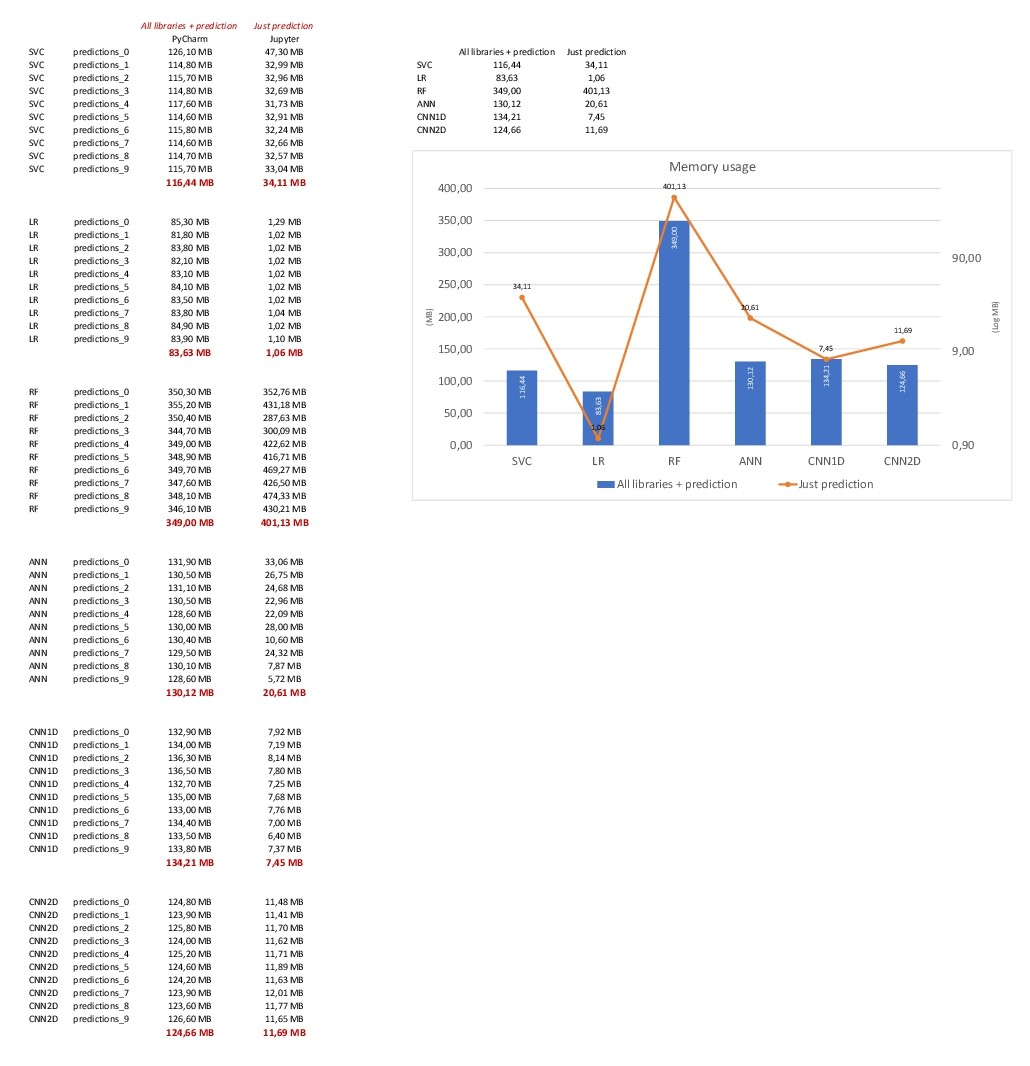

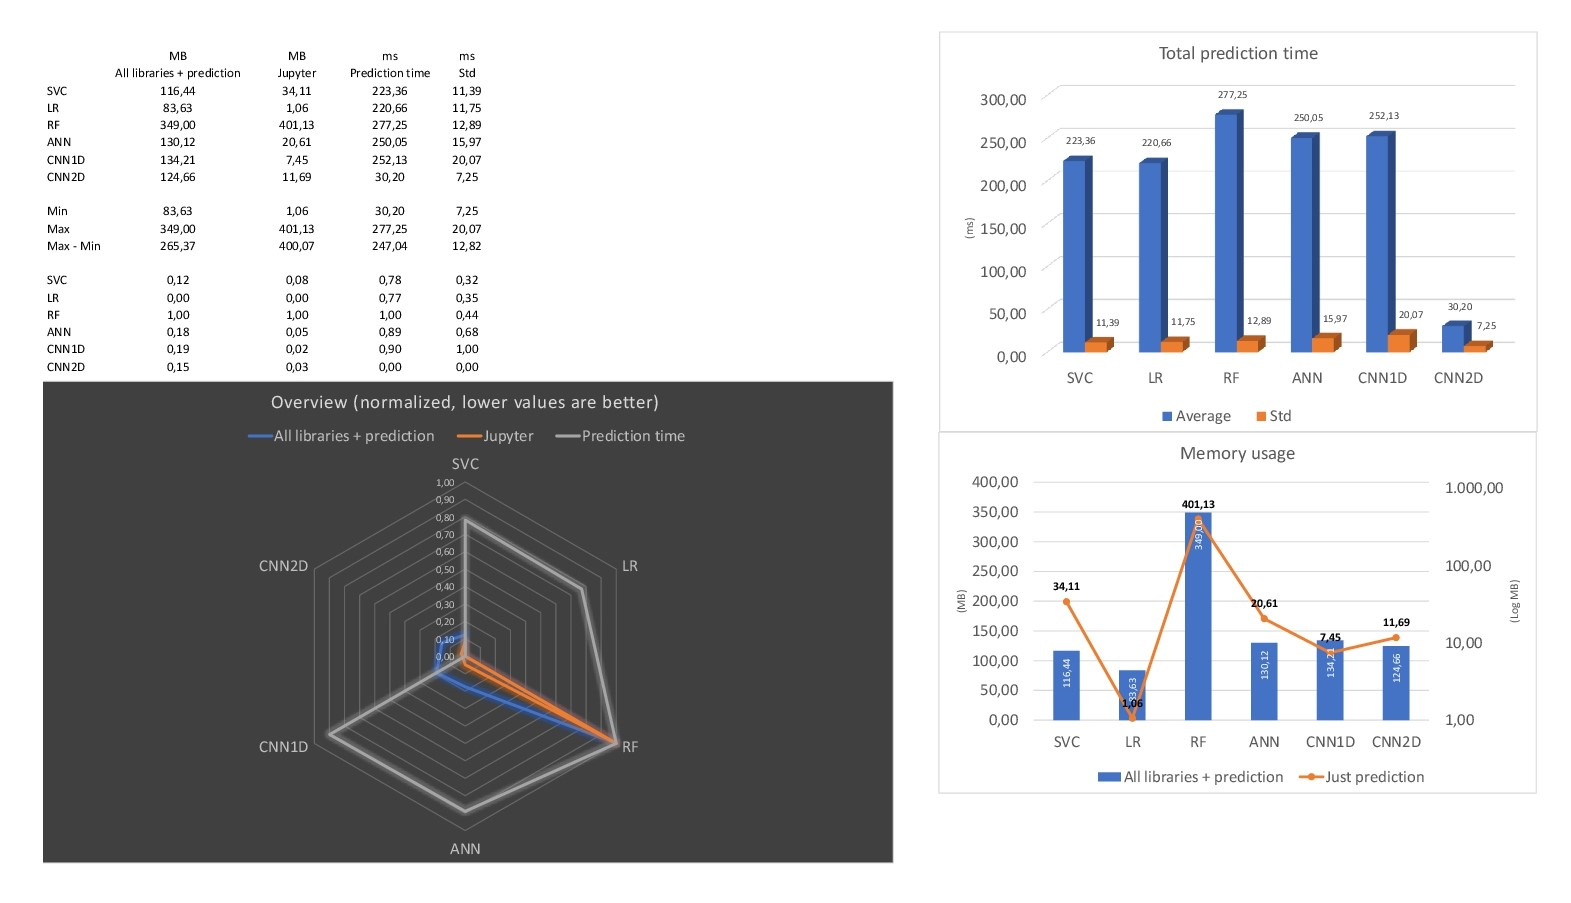

***

# End of the notebook